# Práctica 5: Aprendizaje por refuerzo
# Inteligencia Artificial
# Grado en Ingeniería Informática - Ingeniería del Software
# Universidad de Sevilla

[Gymnasium](https://gymnasium.farama.org/) es una biblioteca Python de código abierto que proporciona una interfaz estándar para la comunicación entre entornos y algoritmos de aprendizaje por refuerzo, facilitando de esta manera el desarrollo y comparación de estos últimos.

Esta práctica presenta una introducción a esa biblioteca, mostrando cómo construir un entorno de aprendizaje por refuerzo concreto. Posteriormente se implementan diversos algoritmos de aprendizaje por refuerzo, aplicándolos a ese entorno y comparando los resultados obtenidos.

El entorno a construir pretende simular un robot que se desplaza por una cuadrícula con 3 filas y 4 columnas, con el objetivo de, partiendo de una celda inicial arbitraria, alcanzar la celda superior derecha de la cuadrícula, pero evitando, en la medida de lo posible, pasar por la celda inmediatamente inferior a esa celda objetivo. Además, la celda de la segunda fila y segunda columna no es accesible.

<img src="Cuadrícula.png" width="150" height="120" style="display: block; margin: 0 auto">

En cada celda, las acciones aplicables son desplazarse una celda en cada una de las 4 posibles direcciones (arriba, abajo, izquierda y derecha). Sin embargo, es posible que, en lugar de moverse en la dirección indicada, el robot se mueva en una dirección perpendicular a ella. La probabilidad de que el robot se mueva en la dirección indicada es de 0.8, mientras que, para cada dirección perpendicular, la probabilidad de que se mueva en esa dirección es de 0.1.

Si al tratar de desplazarse el robot choca con el borde exterior de la cuadrícula o con la celda no accesible, entonces no se desplaza y permanece en la celda donde se encontraba.

Como se pretende que el robot aprenda a alcanzar la celda objetivo lo antes posible, se establece una recompensa de -0.04 para cada celda. Para que también aprenda a evitar la celda inferior a la objetivo, se establece una recompensa de -1 para esa celda. Las acciones no tienen coste.

Para la construcción de entornos de aprendizaje por refuerzo, la bilbioteca Gymnasium provee fundamentalmente de tres ingredientes:

1. Una [clase de objetos `Env` ](https://gymnasium.farama.org/api/env/) que representa el entorno de manera abstracta. Para crear un entorno concreto se debe implementar una clase de objetos que herede de la clase `Env` y que disponga de los siguientes atributos y métodos:
   * Un [atributo `observation_space`](https://gymnasium.farama.org/api/env/#gymnasium.Env.observation_space) que guarde el espacio de posibles estados del entorno.
   * Un [atributo `action_space`](https://gymnasium.farama.org/api/env/#gymnasium.Env.action_space) que guarde el espacio de posibles acciones del entorno.
   * Un [atributo `reward_range`](https://gymnasium.farama.org/api/env/#gymnasium.Env.reward_range) que guarde el intervalo de posibles recompensas del entorno.
   * Un [método `reset`](https://gymnasium.farama.org/api/env/#gymnasium.Env.reset) que reinicie el entorno a un estado inicial. Debe implementarse con argumentos opcionales `seed`, para establecer la semilla del generador de números aleatorios del entorno, y `options`, para proporcionar información adicional de cómo reiniciar el entorno. Debe devolver un elemento del espacio de estados (el estado inicial) y un diccionario con posible información adicional.
   * Un [método `step`](https://gymnasium.farama.org/api/env/#gymnasium.Env.step) que ejecute una acción según la dinámica del entorno. Debe implementarse con un argumento `action` como elemento del espacio de acciones. Debe devolver un elemento del espacio de estados (el nuevo estado), la recompensa obtenida (que debería estar dentro del intervalo `reward_range`), dos valores booleanos indicando si el episodio ha terminado (por haber alcanzado un estado terminal) o se ha truncado (por ejemplo, por haber alcanzado el límite de pasos a realizar, como se verá más adelante en la práctica) y un diccionario con posible información adicional. Cuando se alcance el final de un episodio (por terminación o por truncamiento), será necesario ejecutar `reset` para iniciar un nuevo episodio.
2. Una [colección de espacios](https://gymnasium.farama.org/api/spaces/) para su uso como valores de los atributos `observation_space` y  `action_space`. Los espacios implementados en Gymnasium disponen, en general, de los siguientes atributos y métodos:
   * Un [atributo `shape`](https://gymnasium.farama.org/api/spaces/#gymnasium.spaces.space.Space.shape) que guarda la forma (el tamaño de cada dimensión) del espacio.
   * Un [atributo `dtype`](https://gymnasium.farama.org/api/spaces/#gymnasium.spaces.Space.dtype) que guarda el tipo de dato de los elementos del espacio.
   * Un [método `contains`](https://gymnasium.farama.org/api/spaces/#gymnasium.spaces.space.Space.contains) que comprueba si el argumento recibido pertenece o no al espacio.
   * Un [método `sample`](https://gymnasium.farama.org/api/spaces/#gymnasium.spaces.space.Space.sample) que genera aleatoriamente un elemento del espacio.
   * Un [método `seed`](https://gymnasium.farama.org/api/spaces/#gymnasium.spaces.space.Space.seed) que establece la semilla del generador de números aleatorios del espacio.
      
   Los espacios de Gymnasium utilizados en esta práctica son:
   * El [espacio `Box`](https://gymnasium.farama.org/api/spaces/fundamental/#box), que representa el producto cartesiano de intervalos numéricos cerrados, posiblemente no acotados en algún o en ambos extremos. Deben usarse los argumentos `low` y `high` para especificar como arrays de Numpy los extremos inferiores y superiores, respectivamente, de los intervalos y el argumento `dtype` para especificar si los intervalos son de números reales o de números enteros.
   * El [espacio `Discrete`](https://gymnasium.farama.org/api/spaces/fundamental/#discrete), que representa un conjunto finito de números enteros. Deben usarse los argumentos `n` y `start` (con valor por defecto 0) para crear el conjunto  $\{\mathit{start}, \mathit{start} + 1, \dotsc, \mathit{start} + n - 1\}$.
3. Un [conjunto de envolturas](https://gymnasium.farama.org/api/wrappers/), que son una forma conveniente de modificar un entorno existente sin tener que alterar directamente el código subyacente y que además se pueden encadenar para combinar sus efectos. Las envolturas utilizadas en esta práctica son:
   * La [envoltura `TimeLimit`](https://gymnasium.farama.org/api/wrappers/misc_wrappers/#gymnasium.wrappers.TimeLimit) que hará que se emita una señal de truncamiento si se excede un número máximo de pasos en el episodio.
   * La [envoltura `RecordEpisodeStatistics`](https://gymnasium.farama.org/api/wrappers/misc_wrappers/#gymnasium.wrappers.RecordEpisodeStatistics) que llevará un registro de las recompensas acumuladas y la duración de los episodios.

Estamos ya en condiciones de implementar nuestro entorno de aprendizaje por refuerzo. Para ello:
* Definiremos el espacio de estados como una caja con coordenada $x$ en el intervalo [0, 3] de números enteros y coordenada $y$ en el intervalo [0, 2] de números enteros.
* Definiremos el espacio de acciones como el conjunto $\{0, 1, 2, 3\}$, donde los elementos representanlas acciones desplazarse hacia arriba, hacia abajo, hacia la izquierda y hacia la derecha, respectivamente.
* Definiermos el método `reset` de tal forma que el estado inicial sea la celda inferior izquierda, pero que también se pueda generar aleatoriamente de forma opcional.
* Definiremos el método `step` para que implemente la dinámica del sistema.

In [1]:
import numpy as np

In [4]:
from gymnasium import Env
from gymnasium.spaces import Box, Discrete

In [5]:
class CuadriculaEnv(Env):
    def __init__(self):
        self.espacio_de_estados = Box(low=np.array([0, 0]),
                                      high=np.array([3, 2]),
                                      dtype=int)
        self.espacio_de_acciones = Discrete(n=4)
        self.reward_range = (-1, -.04)
        self._efectos_de_acciones = {0: np.array([[0, 1], [-1, 0], [1, 0]]),
                                    1: np.array([[0, -1], [-1, 0], [1, 0]]),
                                    2: np.array([[-1, 0], [0, 1], [0, -1]]),
                                    3: np.array([[1, 0], [0, 1], [0, -1]])}
    
    # Este es un método auxiliar que facilita la implementación de las acciones
    # y, como veremos posteriormente, el cálculo de sus tablas de probabilidad
    def obten_posibles_movimientos(self, action):
        return self._efectos_de_acciones[action]
    
    def reset(self, seed=None, options={'aleatorio': False}):
        # En su caso, se establece la semilla de los generadores de números
        # aleatorios del entorno y los espacios de estados y de acciones
        if seed is not None:
            super().reset(seed=seed)
            self.espacio_de_estados.seed(seed)
            self.espacio_de_acciones.seed(seed)
        # La posición inicial del robot es la celda inferior izquierda
        # salvo que se indique que debe generarse aleatoriamente
        if (isinstance(options, dict) and
            options.get('aleatorio')):
            while True:
                posicion_inicial = self.espacio_de_estados.sample()
                if (not np.array_equal(posicion_inicial, [1, 1]) and
                    not np.array_equal(posicion_inicial, [3, 2])):
                    break
        else:
            posicion_inicial = np.array([0, 0])
        # El atributo privado estado_actual guarda la posición del robot en
        # cada momento
        self._estado_actual = posicion_inicial
        return posicion_inicial, {}
    
    def step(self, action):
        # La recompensa se obtiene a partir del estado de partida
        recompensa = (-1 if np.array_equal(self._estado_actual, [3, 1])
                      else -.04)
        # La dinámica del sistema se implementa sumando a la posición actual
        # del robot el vector que representa la dirección del movimiento,
        # elegida esta aleatoriamente según la acción a aplicar
        posibles_movimientos = self.obten_posibles_movimientos(action)
        movimiento_real = self.np_random.choice(posibles_movimientos,
                                                p=[.8, .1, .1])
        nuevo_estado = self._estado_actual + movimiento_real
        # Si la nueva posición está fuera de la cuadrícula o es la celda no
        # accesible, entonces el robot no se mueve
        if (not self.espacio_de_estados.contains(nuevo_estado) or
            np.array_equal(nuevo_estado, [1, 1])):
            nuevo_estado = self._estado_actual
        # Se guarda la nueva posición en el atributo privado estado_actual
        self._estado_actual = nuevo_estado
        # Se comprueba si se ha alcanzado el estado terminal
        terminado = np.array_equal(nuevo_estado, [3, 2])
        return nuevo_estado, recompensa, terminado, False, {}

Para crear el entorno basta crear una instancia de la clase de objetos `CuadriculaEnv`.

In [6]:
cuadricula = CuadriculaEnv()

El método `reset` reinicia el entorno estableciendo la celda (0, 0) como posición inicial del robot.

In [7]:
cuadricula.reset()

(array([0, 0]), {})

Pero también puede indicarse que la posición inicial sea una celda aleatoria, en cuyo caso es conviente también establecer una semilla aleatoria, para obtener un resultado reproducible.

In [8]:
cuadricula.reset(seed=3432894, options={'aleatorio': True})

(array([1, 2]), {})

El método `step` desplaza el robot según la dirección indicada y la dinámica del sistema.

In [9]:
# La acción abajo no mueve al robot, ya que la celda (1, 1) no es accesible
cuadricula.step(1)

(array([1, 2]), -0.04, False, False, {})

In [10]:
# Pero esta vez, aleatoriamente el robot se desplaza hacia la derecha, en
# lugar de hacia abajo
cuadricula.step(1)

(array([2, 2]), -0.04, False, False, {})

In [11]:
# La acción derecha hace, entonces, que el robot alcance la celda objetivo
cuadricula.step(3)

(array([3, 2]), -0.04, True, False, {})

El objetivo de la práctica a partir de este punto es ilustrar los conceptos y algoritmos de aprendizaje por refuerzo explicados en las clases teóricas. Para ello, las implementaciones realizadas deberán ser externas al entorno `cuadricula`, interaccionando con él únicamente a través de sus atributos y métodos definidos de forma pública. Además, para conseguir la reproducibilidad del cuaderno de Jupyter, cada vez que se vaya a interaccionar con el entorno se realizará un reinicio inicial con una determinada semilla aleatoria.

El primer concepto a considerar es el de política de acciones, que para nuestro entorno deberá asociar un movimiento del robot a cada celda. En principio, la forma natural de implementar una política sería mediante una estructura de tipo diccionario, pero en este caso, para facilitar su representación, usaremos arrays de Numpy con forma (4, 3), de manera que el primer índice corresponde a la coordenada $x$ y el segundo a la coordenada $y$ (en correspondencia con el espacio de estados del entorno).

Las siguientes dos funciones construyen una representación de las políticas como arrays de cadenas que, al mostrarlos por pantalla, ofrecen una visualización directa de las acciones asociadas a cada celda.

In [12]:
def representa_accion(accion):
    representaciones_de_acciones = {0: '↑', 1: '↓', 2: '←', 3: '→'}
    return representaciones_de_acciones[accion]

In [13]:
def representa_politica(politica):
    representacion = np.vectorize(representa_accion)(politica)
    representacion[1, 1] = 'X'
    representacion[3, 2] = 'T'
    return np.flipud(representacion.T)

Como primer ejemplo, consideramos la política que asocia la acción derecha a cada celda.

In [15]:
politica_siempre_derecha = np.full((4, 3), 3)
print(representa_politica(politica_siempre_derecha))

[['→' '→' '→' 'T']
 ['→' 'X' '→' '→']
 ['→' '→' '→' '→']]


La siguiente función implementa la ejecución de un episodio del entorno indicado, siguiendo la política especificada. Un episodio consiste de la ejecución del método `reset`, para reiniciar el entorno, seguido de la ejecución reiterada del método `step` hasta que se alcance un estado terminal o se trunque el episodio. La función muestra por pantalla la acción ejecutada, la recompensa obtenida y el nuevo estado alcanzado en cada paso y devuelve el diccionario de información del último paso realizado (la utilidad de devolver esto como resultado la veremos más adelante).

In [16]:
def ejecuta_episodio_cuadricula(entorno, politica):
    recompensa_acumulada = 0
    estado, info = entorno.reset()
    print(f'Estado inicial: {estado}')
    while True:
        accion = politica[tuple(estado)]
        estado, recompensa, terminado, truncado, info = entorno.step(accion)
        recompensa_acumulada += recompensa
        print(f'Acción: {representa_accion(accion)}',
              f'   Recompensa: {recompensa:.2f}',
              f'   Nuevo estado: {estado}')
        print(f'Recompensa acumulada: {recompensa_acumulada:.2f}')
        if terminado or truncado:
            break
    return info

A continuación ejecutamos un episodio de la cuadrícula siguiendo la política de tratar de ir siempre hacia la derecha.

In [17]:
cuadricula.reset(seed=3958723)
ejecuta_episodio_cuadricula(cuadricula,
                            politica_siempre_derecha)

Estado inicial: [0 0]
Acción: →    Recompensa: -0.04    Nuevo estado: [0 0]
Recompensa acumulada: -0.04
Acción: →    Recompensa: -0.04    Nuevo estado: [0 0]
Recompensa acumulada: -0.08
Acción: →    Recompensa: -0.04    Nuevo estado: [1 0]
Recompensa acumulada: -0.12
Acción: →    Recompensa: -0.04    Nuevo estado: [2 0]
Recompensa acumulada: -0.16
Acción: →    Recompensa: -0.04    Nuevo estado: [3 0]
Recompensa acumulada: -0.20
Acción: →    Recompensa: -0.04    Nuevo estado: [3 0]
Recompensa acumulada: -0.24
Acción: →    Recompensa: -0.04    Nuevo estado: [3 0]
Recompensa acumulada: -0.28
Acción: →    Recompensa: -0.04    Nuevo estado: [3 0]
Recompensa acumulada: -0.32
Acción: →    Recompensa: -0.04    Nuevo estado: [3 0]
Recompensa acumulada: -0.36
Acción: →    Recompensa: -0.04    Nuevo estado: [3 0]
Recompensa acumulada: -0.40
Acción: →    Recompensa: -0.04    Nuevo estado: [3 0]
Recompensa acumulada: -0.44
Acción: →    Recompensa: -0.04    Nuevo estado: [3 0]
Recompensa acumulada: 

{}

Tras realizar 18 pasos, el robot alcanza la celda objetivo y, por tanto, el episodio termina. En este caso se ha generado un episodio corto, pero es perfectamente posible que se generen episodios excesivamente largos. Usando la envoltura `TimeLimit`, se puede limitar fácilmente la longitud de los episodios, truncándolos cuando se alcance el número de pasos especificado.

In [15]:
from gymnasium.wrappers import TimeLimit

In [16]:
cuadricula_con_tiempo_limite = TimeLimit(cuadricula,
                                         max_episode_steps=10)

Ahora el mismo episodio anterior se truncaría tras diez pasos.

In [17]:
cuadricula_con_tiempo_limite.reset(seed=3958723)
ejecuta_episodio_cuadricula(cuadricula_con_tiempo_limite,
                            politica_siempre_derecha)

Estado inicial: [0 0]
Acción: →    Recompensa: -0.04    Nuevo estado: [0 0]
Recompensa acumulada: -0.04
Acción: →    Recompensa: -0.04    Nuevo estado: [0 0]
Recompensa acumulada: -0.08
Acción: →    Recompensa: -0.04    Nuevo estado: [1 0]
Recompensa acumulada: -0.12
Acción: →    Recompensa: -0.04    Nuevo estado: [2 0]
Recompensa acumulada: -0.16
Acción: →    Recompensa: -0.04    Nuevo estado: [3 0]
Recompensa acumulada: -0.20
Acción: →    Recompensa: -0.04    Nuevo estado: [3 0]
Recompensa acumulada: -0.24
Acción: →    Recompensa: -0.04    Nuevo estado: [3 0]
Recompensa acumulada: -0.28
Acción: →    Recompensa: -0.04    Nuevo estado: [3 0]
Recompensa acumulada: -0.32
Acción: →    Recompensa: -0.04    Nuevo estado: [3 0]
Recompensa acumulada: -0.36
Acción: →    Recompensa: -0.04    Nuevo estado: [3 0]
Recompensa acumulada: -0.40


{}

Por su parte, la envoltura `RecordEpisodeStatistics` permite recopilar información acerca de los episodios.

* Por un lado, para cada episodio devuelve, en el diccionario de información del último paso (aquí está el sentido de que la función `ejecuta_episodio_cuadricula` se haya implementado para que devuelva ese diccionario como resultado), la recompensa acumulada, la longitud y el coste en tiempo del episodio.
* Por otro lado, añade al entorno los atributos `return_queue` y `length_queue` que recopilan, respectivamente, las recompensas acumuladas y las longitudes de los últimos `deque_size` episodios (con valor por defecto 100).

In [18]:
from gymnasium.wrappers import RecordEpisodeStatistics

In [19]:
cuadricula_con_registro = RecordEpisodeStatistics(cuadricula)

# Nota: se puede ignorar el aviso que se produce

/home/alvaro/Compartidos/Universidad/IAIS-2023-24/Contenido práctico/Entorno.nosync/lib/python3.11/site-packages/gymnasium/core.py:297: UserWarning: WARN: env.num_envs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_envs` for environment variables or `env.get_attr('num_envs')` that will search the reminding wrappers.
  logger.warn(


In [20]:
cuadricula_con_registro.reset(seed=3958723)
ejecuta_episodio_cuadricula(cuadricula_con_registro,
                            politica_siempre_derecha)

Estado inicial: [0 0]
Acción: →    Recompensa: -0.04    Nuevo estado: [0 0]
Recompensa acumulada: -0.04
Acción: →    Recompensa: -0.04    Nuevo estado: [0 0]
Recompensa acumulada: -0.08
Acción: →    Recompensa: -0.04    Nuevo estado: [1 0]
Recompensa acumulada: -0.12
Acción: →    Recompensa: -0.04    Nuevo estado: [2 0]
Recompensa acumulada: -0.16
Acción: →    Recompensa: -0.04    Nuevo estado: [3 0]
Recompensa acumulada: -0.20
Acción: →    Recompensa: -0.04    Nuevo estado: [3 0]
Recompensa acumulada: -0.24
Acción: →    Recompensa: -0.04    Nuevo estado: [3 0]
Recompensa acumulada: -0.28
Acción: →    Recompensa: -0.04    Nuevo estado: [3 0]
Recompensa acumulada: -0.32
Acción: →    Recompensa: -0.04    Nuevo estado: [3 0]
Recompensa acumulada: -0.36
Acción: →    Recompensa: -0.04    Nuevo estado: [3 0]
Recompensa acumulada: -0.40
Acción: →    Recompensa: -0.04    Nuevo estado: [3 0]
Recompensa acumulada: -0.44
Acción: →    Recompensa: -0.04    Nuevo estado: [3 0]
Recompensa acumulada: 

{'episode': {'r': array([-2.6399999], dtype=float32),
  'l': array([18], dtype=int32),
  't': array([0.00293], dtype=float32)}}

Podemos limitar la longitud de los episodios y, a la vez, recopilar información acerca de los mismos encadenando las envolturas.

In [21]:
cuadricula_con_tiempo_limite_y_registro = RecordEpisodeStatistics(
    TimeLimit(
        cuadricula,
        max_episode_steps=10
    ),
    deque_size=5
)
cuadricula_con_tiempo_limite_y_registro.reset(seed=3958723)
for episodio in range(1, 6):
    print(f'Episodio {episodio}:')
    print()
    ejecuta_episodio_cuadricula(cuadricula_con_tiempo_limite_y_registro,
                                politica_siempre_derecha)
    print()
    print()

Episodio 1:

Estado inicial: [0 0]
Acción: →    Recompensa: -0.04    Nuevo estado: [0 0]
Recompensa acumulada: -0.04
Acción: →    Recompensa: -0.04    Nuevo estado: [0 0]
Recompensa acumulada: -0.08
Acción: →    Recompensa: -0.04    Nuevo estado: [1 0]
Recompensa acumulada: -0.12
Acción: →    Recompensa: -0.04    Nuevo estado: [2 0]
Recompensa acumulada: -0.16
Acción: →    Recompensa: -0.04    Nuevo estado: [3 0]
Recompensa acumulada: -0.20
Acción: →    Recompensa: -0.04    Nuevo estado: [3 0]
Recompensa acumulada: -0.24
Acción: →    Recompensa: -0.04    Nuevo estado: [3 0]
Recompensa acumulada: -0.28
Acción: →    Recompensa: -0.04    Nuevo estado: [3 0]
Recompensa acumulada: -0.32
Acción: →    Recompensa: -0.04    Nuevo estado: [3 0]
Recompensa acumulada: -0.36
Acción: →    Recompensa: -0.04    Nuevo estado: [3 0]
Recompensa acumulada: -0.40


Episodio 2:

Estado inicial: [0 0]
Acción: →    Recompensa: -0.04    Nuevo estado: [1 0]
Recompensa acumulada: -0.04
Acción: →    Recompensa: -

In [22]:
cuadricula_con_tiempo_limite_y_registro.return_queue

deque([array([-0.39999995], dtype=float32),
       array([-2.24], dtype=float32),
       array([-0.39999995], dtype=float32),
       array([-1.3599999], dtype=float32),
       array([-0.39999995], dtype=float32)],
      maxlen=5)

In [23]:
cuadricula_con_tiempo_limite_y_registro.length_queue

deque([array([10], dtype=int32),
       array([8], dtype=int32),
       array([10], dtype=int32),
       array([10], dtype=int32),
       array([10], dtype=int32)],
      maxlen=5)

La siguiente función permite ejecutar una cierta cantidad de episodios siguiendo una determinada política.

In [24]:
from tqdm import tqdm

In [25]:
def ejecuta_entorno_cuadricula(entorno, politica, num_episodios):
    for episodio in tqdm(range(num_episodios), ncols=100):
        estado, _ = entorno.reset()
        while True:
            accion = politica[tuple(estado)]
            estado, recompensa, terminado, truncado, _ = entorno.step(accion)
            if terminado or truncado:
                break
    return entorno.return_queue, entorno.length_queue

Procedemos ahora a ejecutar mil episodios siguiendo la política de ir siempre hacia la derecha.

In [26]:
cuadricula_con_registro = RecordEpisodeStatistics(cuadricula,
                                                  deque_size=1000)

In [27]:
cuadricula_con_registro.reset(seed=3958723)
recompensas, longitudes = ejecuta_entorno_cuadricula(cuadricula_con_registro,
                                                     politica_siempre_derecha,
                                                     num_episodios=1000)

100%|██████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 906.43it/s]


La visualización gráfica de las recompensas acumuladas y las longitudes de los episodios muestra que ir siempre hacia la derecha no es una buena política.

In [28]:
import matplotlib.pyplot as plt

In [29]:
def visualiza_histograma_de_episodios(recompensas, longitudes):
    print(f'Recompensa media de los episodios: {np.mean(recompensas)}')
    print(f'Longitud media de los episodios: {np.mean(longitudes)}')
    print()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    ax1.hist(np.array(recompensas).flatten(), bins=10)
    ax1.set_title('Histograma de las recompensas\nacumuladas de los episodios')
    ax1.set_xlabel('Recompensa acumulada')
    ax1.set_ylabel('Frecuencia absoluta')
    ax2.hist(np.array(longitudes).flatten(), bins=10)
    ax2.set_title('Histograma de las longitudes\nde los episodios')
    ax2.set_xlabel('Longitud')
    ax2.set_ylabel('Frecuencia absoluta')

Recompensa media de los episodios: -9.930241584777832
Longitud media de los episodios: 31.032



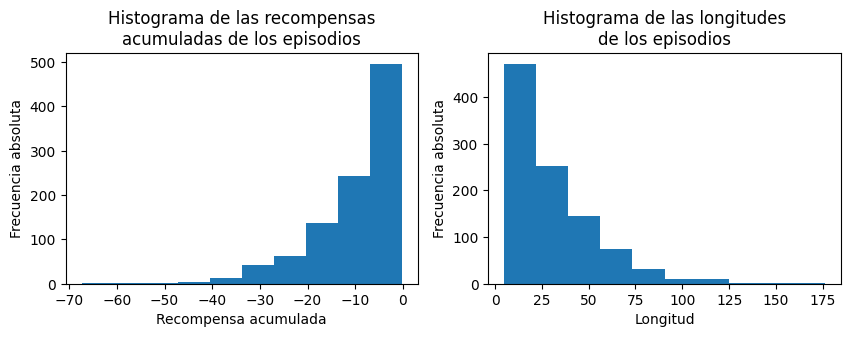

In [30]:
visualiza_histograma_de_episodios(recompensas, longitudes)

Si repetimos el análisis considerando esta vez la política de ir siempre hacia arriba, observamos que tampoco es una buena política porque, aunque en general se obtienen recompensas mayores que con la anterior política, los episodios son, sin embargo, de mayor longitud (¿sabrías dar una explicación intuitiva de por qué ocurre esto?).

In [31]:
politica_siempre_arriba = np.full((4, 3), 0)
print(representa_politica(politica_siempre_arriba))

[['↑' '↑' '↑' 'T']
 ['↑' 'X' '↑' '↑']
 ['↑' '↑' '↑' '↑']]


In [32]:
cuadricula_con_registro.reset(seed=3958723)
recompensas, longitudes = ejecuta_entorno_cuadricula(cuadricula_con_registro,
                                                     politica_siempre_arriba,
                                                     num_episodios=1000)

100%|██████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 449.49it/s]


Recompensa media de los episodios: -2.511758804321289
Longitud media de los episodios: 62.41



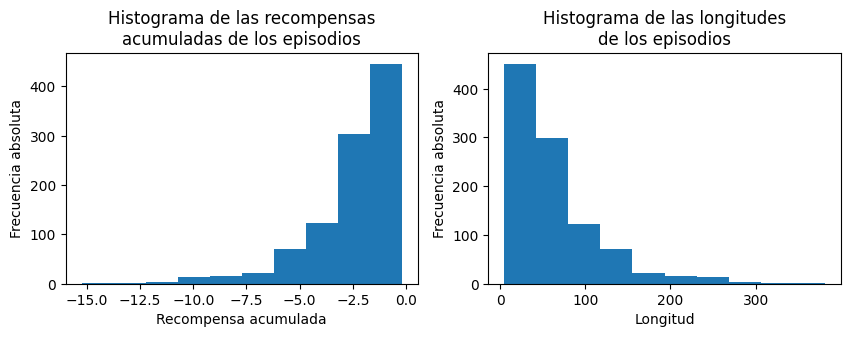

In [33]:
visualiza_histograma_de_episodios(recompensas, longitudes)

## Algoritmos de programación dinámica

A continuación se pretende obtener una política óptima mediante la aplicación de los algoritmos de iteración de valores y de iteración de políticas. Para ello será necesario conocer el modelo de transición del entorno, algo para lo que no está pensada la interfaz propuesta por la biblioteca Gymnasium. Es por ello que nos vemos obligados a extender esa interfaz para que sea posible acceder a ese modelo de transición. Una forma adecuada podría ser implementar una clase de objetos que herede de `CuadriculaEnv`, lo que facilita el acceso a la información relativa al entorno.

In [34]:
class CuadriculaConModeloDeTransicionEnv(CuadriculaEnv):
    def obten_probabilidades_de_transicion(self, accion):
        P = np.zeros((4, 3, 4, 3))
        movimientos = self.obten_posibles_movimientos(accion)
        for x in range(4):
            for y in range(3):
                estado_actual = np.array([x, y])
                if (np.array_equal(estado_actual, [1, 1]) or
                    np.array_equal(estado_actual, [3, 2])):
                    continue
                for movimiento, probabilidad in zip(movimientos, [.8, .1, .1]):
                    nuevo_estado = estado_actual + movimiento
                    if (not self.espacio_de_estados.contains(nuevo_estado) or
                        np.array_equal(nuevo_estado, [1, 1])):
                        nuevo_estado = estado_actual
                    P[tuple(estado_actual)][tuple(nuevo_estado)] += probabilidad
        return P
    
    def obten_recompensas(self):
        R = np.full((4, 3), -.04)
        R[3, 1] = -1
        R[1, 1] = 0
        R[3, 2] = 0
        return R

Cada instancia de esta clase de objetos permite, entonces, obtener las tablas de probabilidades de transición de cada acción y las recompensas asociadas a cada celda.

In [35]:
cuadricula_con_modelo = CuadriculaConModeloDeTransicionEnv()

In [36]:
P_arriba = cuadricula_con_modelo.obten_probabilidades_de_transicion(0)
print(np.flipud(P_arriba[0, 0].T))
print(np.flipud(P_arriba[1, 0].T))

[[0.  0.  0.  0. ]
 [0.8 0.  0.  0. ]
 [0.1 0.1 0.  0. ]]
[[0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.1 0.8 0.1 0. ]]


In [37]:
P_abajo = cuadricula_con_modelo.obten_probabilidades_de_transicion(1)
print(np.flipud(P_abajo[0, 0].T))
print(np.flipud(P_abajo[1, 0].T))

[[0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.9 0.1 0.  0. ]]
[[0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.1 0.8 0.1 0. ]]


In [38]:
P_izquierda = cuadricula_con_modelo.obten_probabilidades_de_transicion(2)
print(np.flipud(P_izquierda[0, 0].T))
print(np.flipud(P_izquierda[1, 0].T))

[[0.  0.  0.  0. ]
 [0.1 0.  0.  0. ]
 [0.9 0.  0.  0. ]]
[[0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.8 0.2 0.  0. ]]


In [39]:
P_derecha = cuadricula_con_modelo.obten_probabilidades_de_transicion(3)
print(np.flipud(P_derecha[0, 0].T))
print(np.flipud(P_derecha[1, 0].T))

[[0.  0.  0.  0. ]
 [0.1 0.  0.  0. ]
 [0.1 0.8 0.  0. ]]
[[0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.2 0.8 0. ]]


In [40]:
R = cuadricula_con_modelo.obten_recompensas()
print(np.flipud(R.T))

[[-0.04 -0.04 -0.04  0.  ]
 [-0.04  0.   -0.04 -1.  ]
 [-0.04 -0.04 -0.04 -0.04]]


Para una mayor eficiencia, las implementaciones de los algoritmos de iteración de valores y de iteración de políticas hacen uso del álgebra matricial, apoyándose en la biblioteca Numpy.

In [41]:
class IteracionDeValores:
    def __init__(self, entorno, gamma, epsilon):
        self.gamma = gamma
        self.epsilon = epsilon
        self.probabilidades = [
            entorno.obten_probabilidades_de_transicion(accion).reshape(12, 12)
            for accion in range(4)
        ]
        self.recompensas = entorno.obten_recompensas().reshape(12, 1)
        self.utilidades_estados = np.zeros((12, 1))
    
    def obten_utilidades_actualizadas(self):
        return np.max(
            np.concatenate(
                [self.recompensas +
                 self.gamma * P @ self.utilidades_estados
                 for P in self.probabilidades],
                axis=1
            ),
            axis=1, keepdims=True
        )
    
    def obten_politica_voraz(self):
        politica = np.argmax(
            np.concatenate(
                [self.recompensas +
                 self.gamma * P @ self.utilidades_estados
                 for P in self.probabilidades],
                axis=1
            ),
            axis=1, keepdims=True
        )
        return politica.reshape(4, 3)
    
    def ejecuta_algoritmo(self, verboso=False):
        i = 0
        if verboso:
            print('Utilidades iniciales de los estados:')
            print(np.flipud(self.utilidades_estados.reshape(4, 3).T))
        while True:
            i += 1
            nuevas_utilidades = self.obten_utilidades_actualizadas()
            diferencia_entre_utilidades = np.linalg.norm(
                self.utilidades_estados - nuevas_utilidades,
                ord=np.inf
            )
            self.utilidades_estados = nuevas_utilidades
            if verboso:
                print()
                print(f'Nuevas utilidades de los estados en la iteración {i}:')
                print(np.flipud(self.utilidades_estados.reshape(4, 3).T))
                print(f'Diferencia respecto a la iteración {i - 1}:',
                      diferencia_entre_utilidades)
            if diferencia_entre_utilidades < self.epsilon:
                break
        return self.obten_politica_voraz()

In [42]:
class IteracionDePoliticas:
    def __init__(self, entorno, gamma):
        self.gamma = gamma
        self.probabilidades = [
            entorno.obten_probabilidades_de_transicion(accion).reshape(12, 12)
            for accion in range(4)
        ]
        self.recompensas = entorno.obten_recompensas().reshape(12, 1)
        self.politica = np.array(
            [entorno.unwrapped.espacio_de_acciones.sample()
             for _ in range(12)],
            dtype='int'
        )
    
    def obten_utilidades_inducidas(self):
        A = np.stack([self.probabilidades[self.politica[s]][s, :]
                      for s in range(12)])
        A = np.identity(12) - self.gamma * A
        return np.linalg.solve(A, self.recompensas)
    
    def obten_politica_voraz(self, utilidades_estados):
        return np.argmax(
            np.concatenate(
                [self.recompensas +
                 self.gamma * P @ utilidades_estados
                 for P in self.probabilidades],
                axis=1
            ),
            axis=1
        )
    
    def ejecuta_algoritmo(self, verboso=False):
        i = 0
        if verboso:
            print('Política inicial:')
            print(representa_politica(self.politica.reshape(4, 3)))
        while True:
            utilidades_estados = self.obten_utilidades_inducidas()
            if verboso:
                print()
                print(f'Utilidades inducida por la política de la iteración {i}:')
                print(np.flipud(utilidades_estados.reshape(4, 3).T))
            i += 1
            nueva_politica = self.obten_politica_voraz(utilidades_estados)
            if verboso:
                print(f'Política voraz obtenida en la iteración {i}:')
                print(representa_politica(nueva_politica.reshape(4, 3)))            
            if np.array_equal(nueva_politica, self.politica):
                break
            self.politica = nueva_politica
        return self.politica.reshape(4, 3)

Ejecutamos el algoritmo de iteración de valores para obtener una política mejor que las políticas anteriores de ir siempre hacia la derecha o siempre hacia arriba.

In [43]:
iteracion_de_valores = IteracionDeValores(cuadricula_con_modelo, .9, 0.1)

In [44]:
politica_iv = iteracion_de_valores.ejecuta_algoritmo(verboso=True)

Utilidades iniciales de los estados:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Nuevas utilidades de los estados en la iteración 1:
[[-0.04 -0.04 -0.04  0.  ]
 [-0.04  0.   -0.04 -1.  ]
 [-0.04 -0.04 -0.04 -0.04]]
Diferencia respecto a la iteración 0: 1.0

Nuevas utilidades de los estados en la iteración 2:
[[-0.076  -0.076  -0.0472  0.    ]
 [-0.076   0.     -0.076  -1.0324]
 [-0.076  -0.076  -0.076  -0.076 ]]
Diferencia respecto a la iteración 1: 0.03600000000000001


In [45]:
print(representa_politica(politica_iv))

[['↑' '→' '→' 'T']
 ['↑' 'X' '←' '←']
 ['↑' '↑' '↑' '↓']]


In [46]:
cuadricula_con_modelo_y_registro = RecordEpisodeStatistics(
    cuadricula_con_modelo,
    deque_size=1000
)

/home/alvaro/Compartidos/Universidad/IAIS-2023-24/Contenido práctico/Entorno.nosync/lib/python3.11/site-packages/gymnasium/core.py:297: UserWarning: WARN: env.num_envs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_envs` for environment variables or `env.get_attr('num_envs')` that will search the reminding wrappers.
  logger.warn(


100%|█████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1536.83it/s]


Recompensa media de los episodios: -0.6837999224662781
Longitud media de los episodios: 17.095



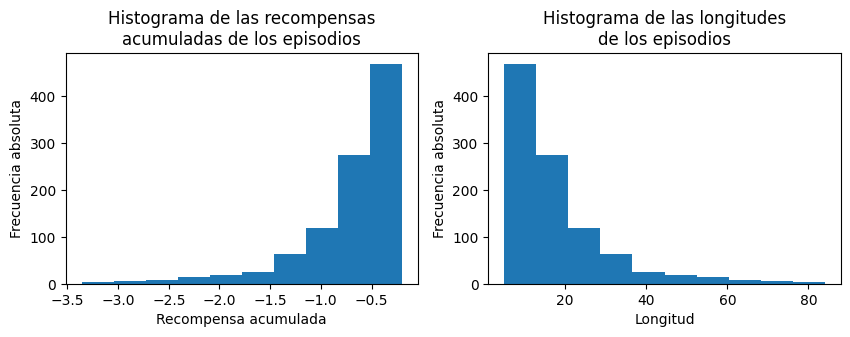

In [47]:
cuadricula_con_modelo_y_registro.reset(seed=3958723)
recompensas, longitudes = ejecuta_entorno_cuadricula(
    cuadricula_con_modelo_y_registro,
    politica_iv,
    num_episodios=1000
)
visualiza_histograma_de_episodios(recompensas, longitudes)

La política obtenida, sin embargo, no es una política óptima, ya que el valor de $\epsilon$ proporcionado ha sido demasiado grande para alcanzar una aproximación suficiente de la función de utilidad máxima de los estados. Ejecutamos ahora el algoritmo de iteración de políticas para obtener una política óptima.

In [48]:
iteracion_de_politicas = IteracionDePoliticas(cuadricula_con_modelo, 0.9)

In [49]:
politica_ip = iteracion_de_politicas.ejecuta_algoritmo(verboso=True)

Política inicial:
[['→' '↓' '↑' 'T']
 ['→' 'X' '↑' '↑']
 ['↑' '→' '←' '↑']]

Utilidades inducida por la política de la iteración 0:
[[-0.34579535 -0.3344814  -0.25036902  0.        ]
 [-0.37607949  0.         -0.3541973  -1.1339316 ]
 [-0.3797853  -0.38697096 -0.38516137 -0.97922558]]
Política voraz obtenida en la iteración 1:
[['→' '→' '→' 'T']
 ['↑' 'X' '←' '↑']
 ['↑' '←' '←' '←']]

Utilidades inducida por la política de la iteración 1:
[[-0.14760435 -0.10870191 -0.06824384  0.        ]
 [-0.17838431  0.         -0.24557659 -1.12318889]
 [-0.20798077 -0.23139775 -0.25132777 -0.3538934 ]]
Política voraz obtenida en la iteración 2:
[['→' '→' '→' 'T']
 ['↑' 'X' '↑' '↑']
 ['↑' '←' '←' '↓']]

Utilidades inducida por la política de la iteración 2:
[[-0.14458952 -0.10522239 -0.06428106  0.        ]
 [-0.17573714  0.         -0.20550847 -1.11922611]
 [-0.20568713 -0.22938382 -0.24577155 -0.32694442]]
Política voraz obtenida en la iteración 3:
[['→' '→' '→' 'T']
 ['↑' 'X' '↑' '↑']
 ['↑' '←' '

In [50]:
print(representa_politica(politica_ip))

[['→' '→' '→' 'T']
 ['↑' 'X' '↑' '↑']
 ['↑' '←' '↑' '↓']]


100%|█████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3190.59it/s]


Recompensa media de los episodios: -0.2820799946784973
Longitud media de los episodios: 6.668



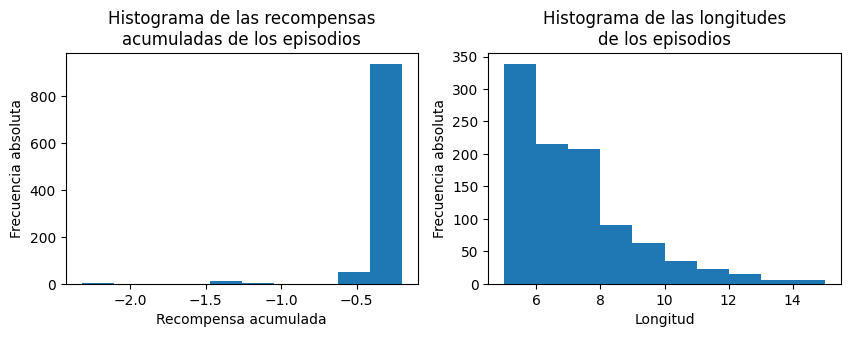

In [51]:
cuadricula_con_modelo_y_registro.reset(seed=3958723)
recompensas, longitudes = ejecuta_entorno_cuadricula(
    cuadricula_con_modelo_y_registro,
    politica_ip,
    num_episodios=1000
)
visualiza_histograma_de_episodios(recompensas, longitudes)

## Algoritmos de aprendizaje por refuerzo

Los algoritmos de aprendizaje por refuerzo no necesitan conocer el modelo de transición del entorno. En su lugar aprenden una política a partir de la interacción con el entorno, para lo que les basta la interfaz de generación de episodios mediante los métodos `reset` y `step` propuesta por la biblioteca Gymnasium.

Es costumbre en el campo del aprendizaje por refuerzo el considerar que se dispone de un agente que interacciona con el entorno siguiendo una determinada política, aprendiendo a mejorar esta según los resultados de esa interacción. Un agente Montecarlo aprendería a partir de episodios completos, mientras que un agente Q-learning aprendería en cada paso de cada episodio.

In [52]:
class AgenteMontecarlo:
    def __init__(self, entorno, gamma):
        self.entorno = entorno
        self.gamma = gamma
        self.politica = np.empty((4, 3), dtype='int')
        for x in range(4):
            for y in range(3):
                accion = entorno.unwrapped.espacio_de_acciones.sample()
                self.politica[x, y] = accion        
        self.tabla_q = np.zeros((4, 3, 4))
        self.Racum = np.empty((4, 3, 4), dtype=object)
        for x in range(4):
            for y in range(3):
                for a in range(4):
                    self.Racum[x, y, a] = []
    
    def _representa_Racum(self):
        def representa_celda(lista_recompensas):
            return ('[' +
                    ' '.join(f'{recompensa:.2}'
                             for recompensa in lista_recompensas) +
                    ']')
        representa_celda = np.vectorize(representa_celda)
        return representa_celda(self.Racum.reshape(12, 4))
    
    def actualiza_tabla_q(self, estado, accion, recompensas):
        utilidad = np.sum(self.gamma ** np.arange(len(recompensas)) *
                          recompensas)
        self.Racum[tuple(estado)][accion].append(utilidad)
        self.tabla_q[tuple(estado)][accion] = np.mean(
            self.Racum[tuple(estado)][accion]
        )
        self.politica[tuple(estado)] = np.argmax(self.tabla_q[tuple(estado)])        
    
    def ejecuta_algoritmo(self, num_episodios, cada_visita=False, verboso=False):
        if verboso:
            print('Tabla inicial de recompensas acumuladas (con redondeo):')
            print(self._representa_Racum())
            print('Tabla Q inicial:')
            print(self.tabla_q.reshape(12, 4))
            print('Política inicialmente aprendida:')
            print(representa_politica(self.politica))
        episodios = (range(1, num_episodios + 1) if verboso
                     else tqdm(range(1, num_episodios + 1), ncols=100))
        for episodio in episodios:
            if verboso:
                print()
                print()
                print(f'Ejecución del episodio {episodio}:')
            estados = []
            acciones = []
            recompensas = []
            estado, _ = self.entorno.reset(options={'aleatorio': True})
            if verboso:
                print()
                print(f'Estado inicial: {estado}')
            accion = self.entorno.unwrapped.espacio_de_acciones.sample()
            while True:
                (nuevo_estado, recompensa,
                 terminado, truncado, _) = self.entorno.step(accion)
                if verboso:
                    print(f'Acción: {representa_accion(accion)}',
                          f'   Recompensa: {recompensa:.2f}',
                          f'   Nuevo estado: {nuevo_estado}')
                estados.append(estado)
                acciones.append(accion)
                recompensas.append(recompensa)
                if terminado or truncado:
                    break
                estado = nuevo_estado
                accion = self.politica[tuple(estado)]
            if verboso:
                print()
                print('Actualización de las tablas y la política:')
            primera_visita = np.full((4, 3, 4), True)
            for i, (estado, accion) in enumerate(zip(estados, acciones)):
                if verboso:
                    print(f'Estado: {estado}',
                          f'  Acción: {representa_accion(accion)}')
                    if not cada_visita:
                        print('Es primera visita'
                              if primera_visita[tuple(estado)][accion]
                              else 'No es primera visita')
                if cada_visita or primera_visita[tuple(estado)][accion]:
                    primera_visita[tuple(estado)][accion] = False
                    self.actualiza_tabla_q(estado, accion, recompensas[i:])
                    if verboso:
                        print('Tabla de recompensas acumuladas (con redondeo):')
                        print(self._representa_Racum())
                        print('Tabla Q:')
                        print(self.tabla_q.reshape(12, 4))
                        print('Política aprendida:')
                        print(representa_politica(self.politica))
        return self.politica

In [53]:
class AgenteQLearning:
    def __init__(self, entorno, gamma, alfa, epsilon):
        self.entorno = entorno
        self.gamma = gamma
        self.alfa = alfa
        self.epsilon = epsilon
        self.tabla_q = np.zeros((4, 3, 4))
    
    def elige_accion(self, estado):
        espacio_de_acciones = self.entorno.unwrapped.espacio_de_acciones
        if self.entorno.np_random.random() < self.epsilon:
            accion_elegida = espacio_de_acciones.sample()
            aleatoria = True
        else:
            accion_elegida = np.argmax(self.tabla_q[tuple(estado)])
            aleatoria = False
        return accion_elegida, aleatoria
    
    def actualiza_tabla_q(self, estado, accion, recompensa, nuevo_estado):
        diferencia_temporal = (
            recompensa + 
            self.gamma * np.max(self.tabla_q[tuple(nuevo_estado)]) -
            self.tabla_q[tuple(estado)][accion]
        )
        self.tabla_q[tuple(estado)][accion] += self.alfa * diferencia_temporal
    
    def ejecuta_algoritmo(self, num_episodios, verboso=False):
        episodios = (range(1, num_episodios + 1) if verboso
                     else tqdm(range(1, num_episodios + 1), ncols=100))
        for episodio in episodios:
            if verboso:
                if episodio > 1:
                    print()
                    print()
                print(f'Ejecución del episodio {episodio}:')
            estado, _ = self.entorno.reset()
            if verboso:
                print()
                print(f'Estado inicial: {estado}')
                print('Tabla Q inicial:')
                print(self.tabla_q.reshape(12, 4))
                print('Política inicialmente aprendida:')
                print(representa_politica(np.argmax(self.tabla_q, axis=2)))
            while True:
                accion, aleatoria = self.elige_accion(estado)
                (nuevo_estado, recompensa,
                 terminado, truncado, _) = self.entorno.step(accion)
                self.actualiza_tabla_q(estado, accion, recompensa, nuevo_estado)
                if verboso:
                    print()
                    print(f'Acción: {representa_accion(accion)}',
                          '(aleatoria)' if aleatoria else '(voraz)',
                          f'   Recompensa: {recompensa:.2f}',
                          f'   Nuevo estado: {nuevo_estado}')
                    print('Tabla Q actual:')
                    print(self.tabla_q.reshape(12, 4))
                    print('Política actualmente aprendida:')
                    print(representa_politica(np.argmax(self.tabla_q, axis=2)))
                if terminado or truncado:
                    break
                estado = nuevo_estado
        return np.argmax(self.tabla_q, axis=2)

Puesto que los episodios generados, sobre todo inicialmente, pueden ser demasiado largos, para el agente Montecarlo es conveniente limitar su longitud mediante la envoltura `TimeLimit` (nótese que el límite 20 usado aquí es excesivamente pequeño, habiéndose elegido así para poder mostrar la traza del algoritmo en un espacio reducido).

In [54]:
cuadricula_con_tiempo_limite_y_registro = RecordEpisodeStatistics(
    TimeLimit(
        cuadricula,
        max_episode_steps=20
    ),
    deque_size=1000
)

In [55]:
cuadricula_con_tiempo_limite_y_registro.reset(seed=3958723)
agente = AgenteMontecarlo(cuadricula_con_tiempo_limite_y_registro,
                          gamma=0.9)

In [56]:
agente.ejecuta_algoritmo(num_episodios=1, verboso=True)

Tabla inicial de recompensas acumuladas (con redondeo):
[['[]' '[]' '[]' '[]']
 ['[]' '[]' '[]' '[]']
 ['[]' '[]' '[]' '[]']
 ['[]' '[]' '[]' '[]']
 ['[]' '[]' '[]' '[]']
 ['[]' '[]' '[]' '[]']
 ['[]' '[]' '[]' '[]']
 ['[]' '[]' '[]' '[]']
 ['[]' '[]' '[]' '[]']
 ['[]' '[]' '[]' '[]']
 ['[]' '[]' '[]' '[]']
 ['[]' '[]' '[]' '[]']]
Tabla Q inicial:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Política inicialmente aprendida:
[['→' '↓' '↑' 'T']
 ['→' 'X' '↑' '↑']
 ['↑' '→' '←' '↑']]


Ejecución del episodio 1:

Estado inicial: [1 0]
Acción: ←    Recompensa: -0.04    Nuevo estado: [1 0]
Acción: →    Recompensa: -0.04    Nuevo estado: [1 0]
Acción: →    Recompensa: -0.04    Nuevo estado: [2 0]
Acción: ←    Recompensa: -0.04    Nuevo estado: [1 0]
Acción: →    Recompensa: -0.04    Nuevo estado: [2 0]
Acción: ←    Recompensa: -0.04    Nuevo estado: [1 0]
Acc

array([[0, 3, 3],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 1]])

In [57]:
agente.ejecuta_algoritmo(num_episodios=1, cada_visita=True, verboso=True)

Tabla inicial de recompensas acumuladas (con redondeo):
[['[]' '[]' '[]' '[]']
 ['[]' '[]' '[]' '[]']
 ['[]' '[]' '[]' '[]']
 ['[]' '[]' '[-0.48]' '[-0.49]']
 ['[]' '[]' '[]' '[]']
 ['[]' '[]' '[]' '[]']
 ['[]' '[]' '[-0.51]' '[]']
 ['[-0.94]' '[]' '[]' '[]']
 ['[]' '[]' '[]' '[]']
 ['[]' '[]' '[]' '[]']
 ['[-1.0]' '[]' '[]' '[]']
 ['[]' '[]' '[]' '[]']]
Tabla Q inicial:
[[ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.         -0.4810511  -0.49005678]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.         -0.51118121  0.        ]
 [-0.94        0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [-1.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Política inic

array([[1, 0, 3],
       [1, 0, 1],
       [0, 1, 0],
       [0, 1, 1]])

In [58]:
politica_Montecarlo = agente.ejecuta_algoritmo(num_episodios=998)

100%|███████████████████████████████████████████████████████████| 998/998 [00:00<00:00, 1905.20it/s]


In [59]:
print(representa_politica(politica_Montecarlo))

[['→' '→' '→' 'T']
 ['↑' 'X' '←' '↑']
 ['↑' '←' '↑' '↓']]


Si representamos gráficamente la evolución del promedio de recompensas acumuladas y longitudes de los episodios, se puede observar cómo el primero aumenta y el segundo disminuye con el número de episodios.

In [60]:
recompensas = cuadricula_con_tiempo_limite_y_registro.return_queue
longitudes = cuadricula_con_tiempo_limite_y_registro.length_queue

In [61]:
def visualiza_serie_temporal_de_episodios(recompensas, longitudes):
    num_episodios = len(recompensas)
    indices_episodios = np.arange(1, num_episodios + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    ax1.plot(indices_episodios, np.cumsum(recompensas) / indices_episodios)
    ax1.set_title('Promedio de las recompensas\nacumuladas de los episodios')
    ax1.set_xlabel('Episodio')
    ax1.set_ylabel('Promedio')
    ax2.plot(indices_episodios, np.cumsum(longitudes) / indices_episodios)
    ax2.set_title('Promedio de las longitudes\nde los episodios')
    ax2.set_xlabel('Episodio')
    ax2.set_ylabel('Promedio')

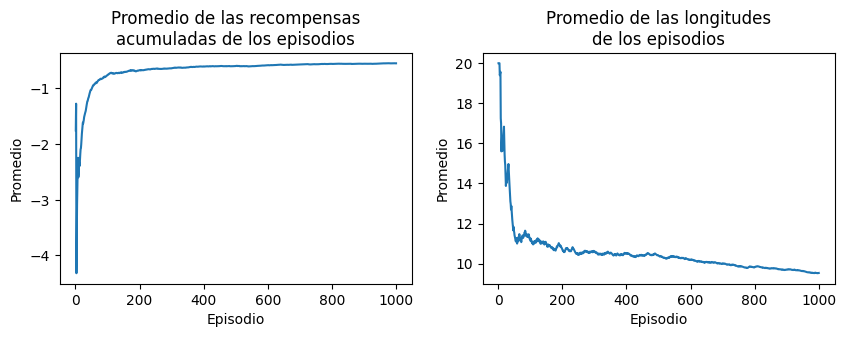

In [62]:
visualiza_serie_temporal_de_episodios(recompensas, longitudes)

Para el agente Q-Learning no se necesita limitar la longitud de los episodios, ya que aprende de manera continua a medida que se van generando estos.

In [63]:
cuadricula_con_registro = RecordEpisodeStatistics(cuadricula,
                                                  deque_size=1000)

In [64]:
cuadricula_con_registro.reset(seed=3958723)
agente = AgenteQLearning(cuadricula_con_registro,
                         gamma=0.9, alfa=0.5, epsilon=0.25)

In [65]:
agente.ejecuta_algoritmo(num_episodios=1, verboso=True)

Ejecución del episodio 1:

Estado inicial: [0 0]
Tabla Q inicial:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Política inicialmente aprendida:
[['↑' '↑' '↑' 'T']
 ['↑' 'X' '↑' '↑']
 ['↑' '↑' '↑' '↑']]

Acción: ↑ (voraz)    Recompensa: -0.04    Nuevo estado: [1 0]
Tabla Q actual:
[[-0.02  0.    0.    0.  ]
 [ 0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.  ]]
Política actualmente aprendida:
[['↑' '↑' '↑' 'T']
 ['↑' 'X' '↑' '↑']
 ['↓' '↑' '↑' '↑']]

Acción: ↑ (voraz)    Recompensa: -0.04    Nuevo estado: [1 0]
Tabla Q actual:
[[-0.02  0.    0.    0.  ]
 [ 0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.  ]
 [-0.02 

array([[1, 0, 0],
       [2, 0, 0],
       [1, 0, 0],
       [0, 1, 0]])

In [66]:
politica_q_learning = agente.ejecuta_algoritmo(num_episodios=999)

100%|███████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 1679.67it/s]


In [67]:
print(representa_politica(politica_q_learning))

[['→' '→' '→' 'T']
 ['↑' 'X' '←' '↑']
 ['↑' '←' '←' '↓']]


La representación gráfica de la evolución del promedio de recompensas acumuladas y longitudes de los episodios muestra que el agente Q-learning ha aprendido más rápidamente a llegar a la celda objetivo que el agente Montecarlo.

In [68]:
recompensas = cuadricula_con_registro.return_queue
longitudes = cuadricula_con_registro.length_queue

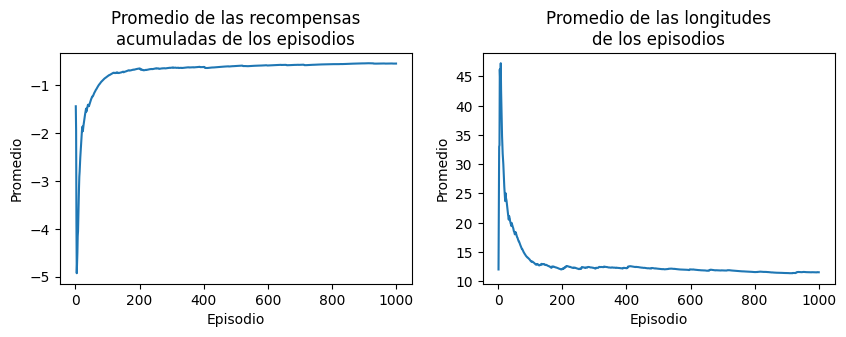

In [69]:
visualiza_serie_temporal_de_episodios(recompensas, longitudes)